<a href="https://colab.research.google.com/github/swilsonmfc/nlp/blob/master/NLPTopicModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Models
![alt text](https://d2908q01vomqb2.cloudfront.net/f1f836cb4ea6efb2a0b1b99f41ad8b103eff4b59/2018/05/22/sagemaker-ntm-1.gif)

# Setup

In [2]:
pip install pycaret

     |████████████████████████████████| 194kB 2.7MB/s 
     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 7.0MB 7.6MB/s 
     |████████████████████████████████| 63.9MB 53kB/s 
     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 389kB 44.3MB/s 
     |████████████████████████████████| 102kB 10.6MB/s 
     |████████████████████████████████| 1.3MB 33.7MB/s 
     |████████████████████████████████| 266kB 41.1MB/s 
     |████████████████████████████████| 133kB 47.8MB/s 
     |████████████████████████████████| 1.2MB 42.2MB/s 
     |████████████████████████████████| 235kB 48.0MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
     |████████████████████████████████| 2.1MB 41.1MB/s 
     |████████████████████████████████| 6.3MB 37.9MB/s 
     |████████████████████████████████| 604kB 41.2MB/s 
     |████████████████████████████████| 71kB 7.7MB/s 
  Created wheel for cufflinks: filename=cufflinks-0.17.0-cp

In [1]:
pip install pyldavis

     |████████████████████████████████| 1.6MB 2.9MB/s 
     |████████████████████████████████| 552kB 19.0MB/s 
  Created wheel for pyldavis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=f105ec98f2c20ca418f7c7e138887c9e106ce884f3afc29b83bffe49d9488997
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=2c1eedc1e8ba24799797592e5aa812e6842ffa9e681da33a929cd6328e0e84db
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyldavis funcy


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import pprint as pp

from sklearn.model_selection import train_test_split

import spacy

from collections import defaultdict

from gensim import corpora
from gensim import models
from gensim import similarities
from gensim.utils import simple_preprocess
from gensim.utils import lemmatize

from pycaret.regression import *

import pyLDAvis
import pyLDAvis.gensim

from wordcloud import WordCloud

In [52]:
import warnings
warnings.simplefilter('ignore')

# Kaggle

In [4]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [ ]:
from google.colab import files
files.upload()

In [6]:
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Data

## Seattle

In [7]:
!kaggle datasets download -d shanelev/seattle-airbnb-listings

  0% 0.00/533k [00:00<?, ?B/s]
100% 533k/533k [00:00<00:00, 72.5MB/s]


In [8]:
!unzip -q seattle-airbnb-listings.zip

In [9]:
!ls

sample_data  seattle_01.csv  seattle-airbnb-listings.zip


In [10]:
seattle_df = pd.read_csv('seattle_01.csv')

In [11]:
seattle_df.head()

,Unnamed: 0,room_id,host_id,room_type,address,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,last_modified,latitude,longitude,location,name,currency,rate_type
0,0,2318,2536,Entire home/apt,"Seattle, WA, United States",21,5.0,8,4.0,2.5,250,2018-12-20 03:46:14.698548,47.610819,-122.290816,0101000020E6100000D449B6BA9C925EC0416326512FCE...,"Casa Madrona - Urban Oasis, 1 block from the P...",USD,nightly
1,1,3335,4193,Entire home/apt,"Seattle, WA, United States",1,NaN,4,2.0,1.0,100,2018-12-20 04:08:45.277643,47.529846,-122.275840,0101000020E61000006FBBD05CA7915EC04DF564FED1C3...,Sweet Seattle Urban Homestead 2 Bdr,USD,nightly
2,2,4291,35749,Private room,"Seattle, WA, United States",63,4.5,2,1.0,1.0,82,2018-12-20 03:04:19.861014,47.687801,-122.313427,0101000020E6100000BDAB1E300F945EC0FB93F8DC09D8...,Sunrise in Seattle Master Suite,USD,nightly
3,3,5682,8993,Entire home/apt,"Seattle, WA, United States",462,5.0,2,0.0,1.0,49,2018-12-20 04:11:25.482975,47.523980,-122.359891,0101000020E6100000FCC7427408975EC009E1D1C611C3...,"Cozy Studio, min. to downtown -WiFi",USD,nightly
4,4,6606,14942,Entire home/apt,"Seattle, WA, United States",134,4.5,2,1.0,1.0,90,2018-12-20 03:12:38.391711,47.654109,-122.337605,0101000020E6100000D47D00529B955EC07782FDD7B9D3...,"Fab, private seattle urban cottage!",USD,nightly


In [12]:
len(seattle_df)

7576

# Latent Semantic Analysis - LSA
* Sometimes called Latent Semantic Indexing - LSI
* Organize documents into topics
* The topics are hidden (latent)
* We can specify how many topics

## Technical Notes
* Construct a Document-Term matrix
  * Rows = Documents
  * Columns = Terms
  * Cells = Frequency of words
* Convert Document-Term matrix into TF-IDF Matrix
  * TF = Term Frequency
  * IDF = Inverse Document Frequency
  * Intuition:
    * TF - Word occurs frequently it's likely important
    * Stopwords are a problem (The, an, and) - occur frequenty in documents
    * IDF - If a word is rare considering all the documents it's likely more important
    * How rare is too rare?  Minimum threshold of appearances

![alt text](https://cdn.searchenginejournal.com/wp-content/uploads/2019/10/screenshot-1.png)

* Use matrix factorization to reduce dimensionality
  * Squeeze to K-dimensions
  * K is the number of topics
* LSA == PCA 
  * PCA - Principal Components
    * Find matrix U * V that approximates TF-IDF matrix
    * Minimize difference between TF-IDF and U * V
  * SVD - Singular value decomposition 
    * Increase explainability by constraining number of topics
  * NNMF - Non-Negative Matrix Factorization 
    * SVD + constraint where U & V > 0
* Truncated SVD yields three matrixes 
  * We can multiply them back together to approximate the original TF-IDF matrix
  * SVD decomposes a matrix into three other matrices. 
  * U* S * VT
  * U [Documents X Topics]
  * S [Topics X Topics] = Amount of Variance Explained
  * VT [Topics X Terms]
![alt text](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/09/Screenshot_7.png)


# Gensim Example 
![alt text](https://repository-images.githubusercontent.com/1349775/202c4680-8f7c-11e9-91c6-745fdcbeffe8)

In [13]:
documents = [
    "Human machine interface for lab abc computer applications May 10, 2000",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

## Documents

In [14]:
pp.pprint(documents)

['Human machine interface for lab abc computer applications May 10, 2000',
 'A survey of user opinion of computer system response time',
 'The EPS user interface management system',
 'System and human system engineering testing of EPS',
 'Relation of user perceived response time to error measurement',
 'The generation of random binary unordered trees',
 'The intersection graph of paths in trees',
 'Graph minors IV Widths of trees and well quasi ordering',
 'Graph minors A survey']


## Tokenize
* Remove stop words
* Make lower case

In [15]:
stoplist = set('for a of the and to in'.split()) # Where else can we get these
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in documents
]
pp.pprint(texts)

[['human',
  'machine',
  'interface',
  'lab',
  'abc',
  'computer',
  'applications',
  'may',
  '10,',
  '2000'],
 ['survey', 'user', 'opinion', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'management', 'system'],
 ['system', 'human', 'system', 'engineering', 'testing', 'eps'],
 ['relation', 'user', 'perceived', 'response', 'time', 'error', 'measurement'],
 ['generation', 'random', 'binary', 'unordered', 'trees'],
 ['intersection', 'graph', 'paths', 'trees'],
 ['graph', 'minors', 'iv', 'widths', 'trees', 'well', 'quasi', 'ordering'],
 ['graph', 'minors', 'survey']]


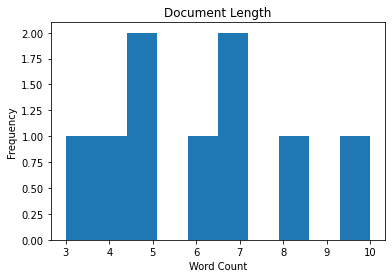

In [16]:
plt.hist([len(t) for t in texts])
plt.title('Document Length')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Low Frequency Words
* Drop words from the tokenized text appearing once

In [17]:
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]
pp.pprint(texts)

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]


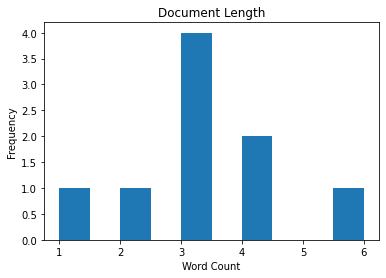

In [18]:
plt.hist([len(t) for t in texts])
plt.title('Document Length')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

## Dictionary

In [19]:
dictionary = corpora.Dictionary(texts)
print(dictionary)
for key in dictionary:
  print(key, dictionary[key])

Dictionary(12 unique tokens: ['computer', 'human', 'interface', 'response', 'survey']...)
0 computer
1 human
2 interface
3 response
4 survey
5 system
6 time
7 user
8 eps
9 trees
10 graph
11 minors


## Bag of Words
* Represented as list of tuples per document (word index, frequency)

In [20]:
corpus = [dictionary.doc2bow(text) for text in texts]
pp.pprint(corpus)

[[(0, 1), (1, 1), (2, 1)],
 [(0, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)],
 [(2, 1), (5, 1), (7, 1), (8, 1)],
 [(1, 1), (5, 2), (8, 1)],
 [(3, 1), (6, 1), (7, 1)],
 [(9, 1)],
 [(9, 1), (10, 1)],
 [(9, 1), (10, 1), (11, 1)],
 [(4, 1), (10, 1), (11, 1)]]


## TF-IDF
* Term Frequency - Inverse Document Frequency
* Represented by a model in Gensim

In [21]:
tfidf = models.TfidfModel(corpus) 
corpus_tfidf = tfidf[corpus]
for doc in corpus_tfidf:
    print(doc)

[(0, 0.5773502691896257), (1, 0.5773502691896257), (2, 0.5773502691896257)]
[(0, 0.44424552527467476), (3, 0.44424552527467476), (4, 0.44424552527467476), (5, 0.3244870206138555), (6, 0.44424552527467476), (7, 0.3244870206138555)]
[(2, 0.5710059809418182), (5, 0.4170757362022777), (7, 0.4170757362022777), (8, 0.5710059809418182)]
[(1, 0.49182558987264147), (5, 0.7184811607083769), (8, 0.49182558987264147)]
[(3, 0.6282580468670046), (6, 0.6282580468670046), (7, 0.45889394536615247)]
[(9, 1.0)]
[(9, 0.7071067811865475), (10, 0.7071067811865475)]
[(9, 0.5080429008916749), (10, 0.5080429008916749), (11, 0.695546419520037)]
[(4, 0.6282580468670046), (10, 0.45889394536615247), (11, 0.6282580468670046)]


## LSA Model
* Why Gensim vs TruncatedSVD?
  * Memory efficient (Constant Size)
  * Streamed corpora
  * One pass corpora (Streaming)
  * Distributed computing 

In [22]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2) 
corpus_lsi = lsi_model[corpus_tfidf]  
lsi_model.print_topics(2, num_words=3)

[(0, '0.703*"trees" + 0.538*"graph" + 0.402*"minors"'),
 (1, '-0.460*"system" + -0.373*"user" + -0.332*"eps"')]

In [23]:
for doc, as_text in zip(corpus_lsi, documents):
    print(doc, as_text)

[(0, 0.06600783396090396), (1, -0.5200703306361851)] Human machine interface for lab abc computer applications May 10, 2000
[(0, 0.1966759285914258), (1, -0.7609563167700044)] A survey of user opinion of computer system response time
[(0, 0.08992639972446452), (1, -0.7241860626752507)] The EPS user interface management system
[(0, 0.07585847652178164), (1, -0.6320551586003426)] System and human system engineering testing of EPS
[(0, 0.10150299184980191), (1, -0.5737308483002951)] Relation of user perceived response time to error measurement
[(0, 0.7032108939378312), (1, 0.16115180214025837)] The generation of random binary unordered trees
[(0, 0.8774787673119834), (1, 0.16758906864659456)] The intersection graph of paths in trees
[(0, 0.9098624686818582), (1, 0.14086553628719048)] Graph minors IV Widths of trees and well quasi ordering
[(0, 0.6165825350569285), (1, -0.053929075663893614)] Graph minors A survey


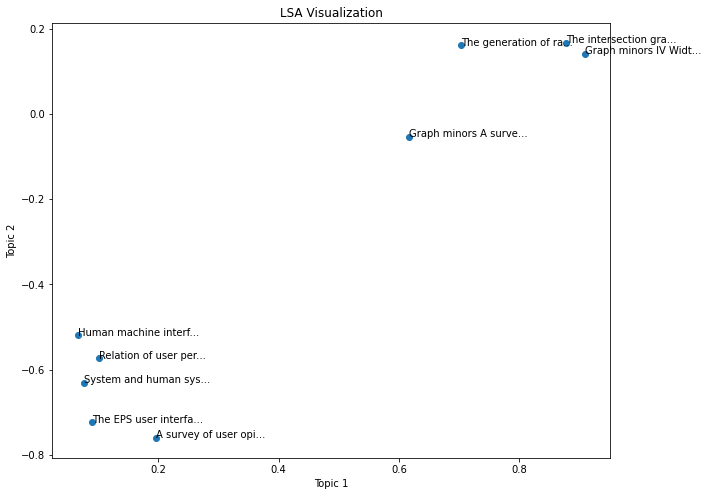

In [24]:
items = []
for doc, as_text in zip(corpus_lsi, documents):
    items.append({'Topic 1':doc[0][1], 'Topic 2': doc[1][1], 'Document': as_text[0:20] + '...'})
data = pd.DataFrame(items)

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(data['Topic 1'], data['Topic 2'])

for index, row in data.iterrows():
    ax.annotate(row['Document'], (row['Topic 1'], row['Topic 2']))

plt.title('LSA Visualization');
plt.xlabel('Topic 1')
plt.ylabel('Topic 2');

In [25]:
data.dtypes

Topic 1     float64
Topic 2     float64
Document     object
dtype: object

## Similarity
* Distance 
* Cosine Similarity

In [26]:
doc = "Human computer interaction"
vec_bow = dictionary.doc2bow(doc.lower().split())
vec_lsi = lsi_model[vec_bow]  # convert the query to LSI space

print(doc)
print(vec_lsi)

Human computer interaction
[(0, 0.07910475117444901), (1, -0.5732835243079404)]


In [27]:
index = similarities.MatrixSimilarity(lsi_model[corpus])
sims = index[vec_lsi]  # perform a similarity query against the corpus
pp.pprint(list(enumerate(sims)))  # print (document_number, document_similarity) 2-tuples

[(0, 0.9999408),
 (1, 0.9946708),
 (2, 0.9999428),
 (3, 0.999879),
 (4, 0.99935204),
 (5, -0.08804217),
 (6, -0.0515742),
 (7, -0.023664713),
 (8, 0.1938726)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


# SpaCy Pipeline
![alt text](https://cdn-images-1.medium.com/freeze/max/1000/1*wqfF41Ysh-kV-fXMDGxSGg.jpeg?q=20)

## Documents

In [28]:
documents = [
    "Human machine interface for lab abc computer applications on May 10, 2000",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

In [29]:
paragraph = '. '.join(documents)
paragraph

'Human machine interface for lab abc computer applications on May 10, 2000. A survey of user opinion of computer system response time. The EPS user interface management system. System and human system engineering testing of EPS. Relation of user perceived response time to error measurement. The generation of random binary unordered trees. The intersection graph of paths in trees. Graph minors IV Widths of trees and well quasi ordering. Graph minors A survey'

## Loading Spacy

In [30]:
import spacy
nlp = spacy.load('en')

## Pipeline

In [31]:
print(nlp.pipe_names)

['tagger', 'parser', 'ner']


## Processing
* Can tokenize document per item
* Can infer sentence boundaries by adding sentencizer to pipeline

In [32]:
nlp = spacy.load('en')
texts_spacy = [nlp(document) for document in documents]
texts_spacy

[Human machine interface for lab abc computer applications on May 10, 2000,
 A survey of user opinion of computer system response time,
 The EPS user interface management system,
 System and human system engineering testing of EPS,
 Relation of user perceived response time to error measurement,
 The generation of random binary unordered trees,
 The intersection graph of paths in trees,
 Graph minors IV Widths of trees and well quasi ordering,
 Graph minors A survey]

In [33]:
nlp_para = spacy.load('en')
nlp_para.add_pipe(nlp.create_pipe('sentencizer'))
texts_spacy = nlp_para(paragraph)
sentences = [sent.string.strip() for sent in texts_spacy.sents]
pp.pprint(sentences)

['Human machine interface for lab abc computer applications on May 10, 2000.',
 'A survey of user opinion of computer system response time.',
 'The EPS user interface management system.',
 'System and human system engineering testing of EPS.',
 'Relation of user perceived response time to error measurement.',
 'The generation of random binary unordered trees.',
 'The intersection graph of paths in trees.',
 'Graph minors IV Widths of trees and well quasi ordering.',
 'Graph minors',
 'A survey']


## Tokens
* Pipeline creates tokens
* Token attributes are populated depending on pipeline steps

In [34]:
texts_spacy = [nlp(document) for document in documents]

rows = []
for text in texts_spacy:
  for token in text:
    rows.append({'token': token.text,
                 'lower': token.lower_, 
                 'lemma': token.lemma_, 
                 'pos': token.pos_,
                 'shape': token.shape_,
                 'dependency': token.dep_,
                 'entity': token.ent_type_, 
                 'tag': token.tag_,
                 'stop': token.is_stop})
pd.DataFrame(rows)[0:10]

,token,lower,lemma,pos,shape,dependency,entity,tag,stop
0,Human,human,human,ADJ,Xxxxx,amod,,JJ,False
1,machine,machine,machine,NOUN,xxxx,compound,,NN,False
2,interface,interface,interface,NOUN,xxxx,ROOT,,NN,False
3,for,for,for,ADP,xxx,prep,,IN,True
4,lab,lab,lab,PROPN,xxx,compound,,NNP,False
5,abc,abc,abc,PROPN,xxx,compound,ORG,NNP,False
6,computer,computer,computer,NOUN,xxxx,compound,,NN,False
7,applications,applications,application,NOUN,xxxx,pobj,,NNS,False
8,on,on,on,ADP,xx,prep,,IN,True
9,May,may,May,PROPN,Xxx,pobj,DATE,NNP,True


## displaCy

In [35]:
import spacy
from spacy import displacy

In [36]:
doc = nlp(documents[0])
displacy.render(doc, style="dep", jupyter=True)

In [37]:
displacy.render(doc, style="ent", jupyter=True)

## SpaCy -> Gensim
* Gensim wants text
* token.text from SpaCy

# Latent Dirichlet Allocation - LDA
* Proposed in 2000 in the genetics field
* Applied to NLP in 2003 by Blei & Ng
* Generative probablistic model of a corpus (collection of documents)
  * Documents can be approximated with random mixtures over latent topics
  * Each topic is represented as a distribution over the words in the vocabulary

## Thought Experiment
* Corpus of Documents
* Latent Topics
  * Sports 
  * Politics
  * Scary
* Documents
  * Given document - what topic?
  * 10% Sports, 80% Politics, 10% Scary
  * 60% Sports, 20% Politics, 20% Scary
  * 33% Sports, 34% Politics, 33% Scary
  * Documents can be a mixture of topics!
* Words 
  * Given topic - what word?
  * Court: 40% Sports, 40% Politics, 20% Scary
  * Ghost: 10% Sports, 10% Politics, 60% Scary
  * Race : 40% Sports, 30% Politics, 10% Scary
  * Win  : 10% Sports, 20% Politics, 10% Scary
  * Words are a distribution over the vocabulary conditioned by the topic

## Dirichlet Distribution
* Hyperparameter alpha controls edge / center
![alt text](https://cdn-images-1.medium.com/max/900/0*mAmRqUT4gRoFj-eo.)

## Technical Notes
* Can we build a machine to generate documents with just dice?
* Approach:
  * How many documents?  Use the size of the corpus.
  * How many words (N) in "document"?  Use the corpus average length and draw from Poisson distribution. 
    * Expected Value = Average Length
    * Variance = Average Length
  * Choose Topic Mix from Dirichlet distribution (Theta)
    * Hyperparameter alpha (is our Dirichlet more focused in the center or to the edges)?
  * For each word (N):
    * Choose a topic (Z) from Multinomial distribution (Theta)
    * Choose a word conditioned on Topic (Z)
    * Note:  We don't write a document, but rather reproduce the "bag"
  * Repeat for each document in corpus
  * Select machine that "reconstructs" the original document the best
  * Repeat process
* After processing we get two matrixes
  * Words X Topics
  * Topics X Documents



# LSA vs LDA

![alt text](https://image2.slideserve.com/3877409/slide21-l.jpg)

* LSA
  * Keep things spread apart that were far apart to start
  * LSA has the advantage of good optimization
* LDA
  * Keep things close that were close together to start
  * More understandable 
  * Tends to keep frequently co-occurring words in the same topic

# Seattle - Dataset
* Use SpaCy to parse "name" field
* Use Gensim to:
  * Transform to tf-idf space
  * Transform to LSA space
  * Build a LDA Model
* Craft features from topics
* Build ML model to forecast AirBnB price

## Documents

In [38]:
documents = seattle_df.name.to_list()
documents[0:10]

['Casa Madrona - Urban Oasis, 1 block from the Park!',
 'Sweet Seattle Urban Homestead 2 Bdr',
 'Sunrise in Seattle Master Suite',
 'Cozy Studio, min. to downtown -WiFi',
 'Fab, private seattle urban cottage!',
 'Glorious sun room w/ memory foambed',
 'Downtown/Convention Ctr B&B - Nice!',
 'The Adorable Sweet Orange Craftsman',
 'The Coolest Tangerine Dream MIL! ',
 'the down home , spacious, central and fab!']

## Tokenize
* Skip stopwords
* Skip punctuation

In [39]:
nlp = spacy.load('en')
tokens = [nlp(document) for document in documents]
tokens[0:10]

[Casa Madrona - Urban Oasis, 1 block from the Park!,
 Sweet Seattle Urban Homestead 2 Bdr,
 Sunrise in Seattle Master Suite,
 Cozy Studio, min. to downtown -WiFi,
 Fab, private seattle urban cottage!,
 Glorious sun room w/ memory foambed,
 Downtown/Convention Ctr B&B - Nice!,
 The Adorable Sweet Orange Craftsman,
 The Coolest Tangerine Dream MIL! ,
 the down home , spacious, central and fab!]

In [40]:
texts = [
         [token.text for token in document
          if not token.is_stop and not token.is_punct]
         for document in tokens
        ]

## Dictionary

In [41]:
dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(4297 unique tokens: ['1', 'Casa', 'Madrona', 'Oasis', 'Park']...)


## Bag of Words

In [42]:
corpus = [dictionary.doc2bow(text) for text in texts]

## TF-IDF

In [43]:
tfidf = models.TfidfModel(corpus) 
corpus_tfidf = tfidf[corpus]

## LSA Model

In [49]:
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=5) 
corpus_lsi = lsi_model[corpus_tfidf]  
lsi_model.print_topics(5, num_words=3)

[(0, '0.329*"Seattle" + 0.274*"Hill" + 0.259*"Private"'),
 (1, '0.535*"Hill" + 0.515*"Capitol" + -0.298*"Seattle"'),
 (2, '0.468*"Place" + 0.455*"Pike" + -0.281*"Hill"'),
 (3, '0.558*"Queen" + 0.534*"Anne" + -0.375*"Seattle"'),
 (4, '0.305*"Lake" + 0.299*"Apt" + 0.283*"near"')]

## LDA Model

### Bag of Words

In [53]:
lda_bow_model = models.LdaModel(corpus, id2word=dictionary, num_topics=5) 
corpus_bow_lda = lda_bow_model[corpus]  
lda_bow_model.print_topics(5, num_words=3)

[(0, '0.026*"Seattle" + 0.019*"Modern" + 0.019*"Private"'),
 (1, '0.041*"Downtown" + 0.028*"Hill" + 0.023*"Apartment"'),
 (2, '0.032*"Place" + 0.031*"Pike" + 0.023*"Home"'),
 (3, '0.070*"Seattle" + 0.021*"Apartment" + 0.020*"Cozy"'),
 (4, '0.044*"Hill" + 0.041*"Seattle" + 0.028*"Capitol"')]

### TF-IDF

In [54]:
lda_model = models.LdaModel(corpus_tfidf, id2word=dictionary, num_topics=5) 
corpus_lda = lda_model[corpus_tfidf]  
lda_model.print_topics(5, num_words=3)

[(0, '0.018*"Hill" + 0.012*"Capitol" + 0.010*"Modern"'),
 (1, '0.016*"Seattle" + 0.013*"Apartment" + 0.010*"Cozy"'),
 (2, '0.014*"Seattle" + 0.013*"Heart" + 0.012*"xx"'),
 (3, '0.025*"Place" + 0.023*"Pike" + 0.011*"Downtown"'),
 (4, '0.014*"Seattle" + 0.013*"Private" + 0.009*"room"')]

# Visualizing Topic Models

## WordClouds

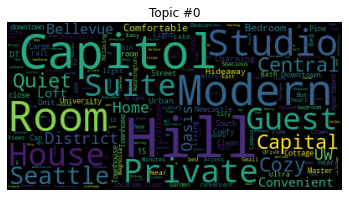

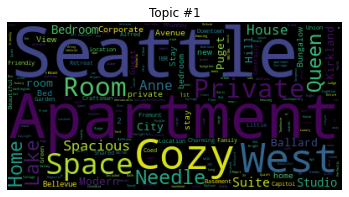

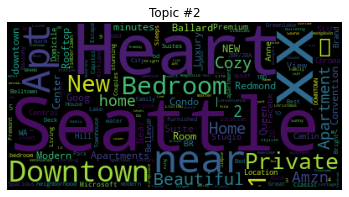

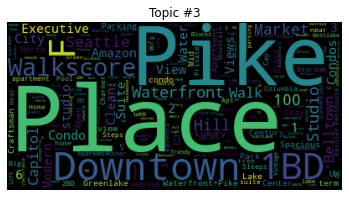

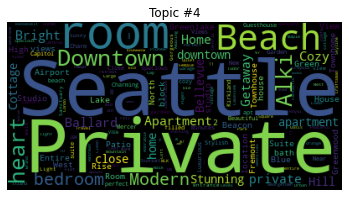

In [68]:
for t in range(lda_model.num_topics):
    plt.figure()
    topic_words = {tup[0]:tup[1] for tup in lda_model.show_topic(t, 200)}
    plt.imshow(WordCloud().fit_words(topic_words))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

## PyLDAVis
* Port of R package by Carson Sievert and Kenny Shirley
* http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

In [60]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.081368  0.049853       1        1  23.820379
3     -0.152977 -0.044309       2        1  20.736782
0      0.050197 -0.096496       3        1  18.918079
4      0.056402 -0.030730       4        1  18.286596
2     -0.034990  0.121683       5        1  18.238161, topic_info=         Term       Freq       Total Category  logprob  loglift
541     Place  92.000000   92.000000  Default  30.0000  30.0000
540      Pike  85.000000   85.000000  Default  29.0000  29.0000
2646       xx  35.000000   35.000000  Default  28.0000  28.0000
683         F  36.000000   36.000000  Default  27.0000  27.0000
90      Heart  46.000000   46.000000  Default  26.0000  26.0000
...       ...        ...         ...      ...      ...      ...
16       Cozy  19.269381  110.554466   Topic5  -5.0438  -0.0453
89    Ballard  16.824886   66.327667   Topic5  -5.1794   0.3299
334     Condo  14.994079   49.309620   Topic5  -5.2946   0.5112
86     Modern  16.329836  108.200790   Topic5  -5.2093  -0.1893
13      Suite  14.913145   98.206635   Topic5  -5.3000  -0.1832

[347 rows x 6 columns], token_table=      Topic      Freq Term
term                      
0         1  0.236149    1
0         2  0.249268    1
0         3  0.091836    1
0         4  0.065597    1
0         5  0.354223    1
...     ...       ...  ...
111       1  0.021605    ★
111       2  0.367280    ★
111       3  0.021605    ★
111       4  0.064814    ★
111       5  0.518513    ★

[655 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 5, 3])

# Seattle Prediction

## Features from Topics

In [69]:
seattle_topic_df = seattle_df.copy()

assignments = [item for item in lda_model.get_document_topics(corpus_lda)]
for index in range(lda_model.num_topics):
  seattle_topic_df[f'lda_topic_{index}'] = [assign[index][1] for assign in assignments]

seattle_topic_df.head()

,Unnamed: 0,room_id,host_id,room_type,address,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,last_modified,latitude,longitude,location,name,currency,rate_type,lda_topic_0,lda_topic_1,lda_topic_2,lda_topic_3,lda_topic_4
0,0,2318,2536,Entire home/apt,"Seattle, WA, United States",21,5.0,8,4.0,2.5,250,2018-12-20 03:46:14.698548,47.610819,-122.290816,0101000020E6100000D449B6BA9C925EC0416326512FCE...,"Casa Madrona - Urban Oasis, 1 block from the P...",USD,nightly,0.122503,0.103927,0.566746,0.103421,0.103403
1,1,3335,4193,Entire home/apt,"Seattle, WA, United States",1,NaN,4,2.0,1.0,100,2018-12-20 04:08:45.277643,47.529846,-122.275840,0101000020E61000006FBBD05CA7915EC04DF564FED1C3...,Sweet Seattle Urban Homestead 2 Bdr,USD,nightly,0.121769,0.105053,0.566547,0.102985,0.103646
2,2,4291,35749,Private room,"Seattle, WA, United States",63,4.5,2,1.0,1.0,82,2018-12-20 03:04:19.861014,47.687801,-122.313427,0101000020E6100000BDAB1E300F945EC0FB93F8DC09D8...,Sunrise in Seattle Master Suite,USD,nightly,0.130520,0.106691,0.550454,0.107328,0.105006
3,3,5682,8993,Entire home/apt,"Seattle, WA, United States",462,5.0,2,0.0,1.0,49,2018-12-20 04:11:25.482975,47.523980,-122.359891,0101000020E6100000FCC7427408975EC009E1D1C611C3...,"Cozy Studio, min. to downtown -WiFi",USD,nightly,0.554109,0.101902,0.140726,0.101815,0.101449
4,4,6606,14942,Entire home/apt,"Seattle, WA, United States",134,4.5,2,1.0,1.0,90,2018-12-20 03:12:38.391711,47.654109,-122.337605,0101000020E6100000D47D00529B955EC07782FDD7B9D3...,"Fab, private seattle urban cottage!",USD,nightly,0.124436,0.102913,0.567930,0.101766,0.102954


## Data Prep

In [70]:
seattle_topic_df.dtypes

Unnamed: 0                int64
room_id                   int64
host_id                   int64
room_type                object
address                  object
reviews                   int64
overall_satisfaction    float64
accommodates              int64
bedrooms                float64
bathrooms               float64
price                     int64
last_modified            object
latitude                float64
longitude               float64
location                 object
name                     object
currency                 object
rate_type                object
lda_topic_0             float64
lda_topic_1             float64
lda_topic_2             float64
lda_topic_3             float64
lda_topic_4             float64
dtype: object

In [71]:
columns = ['room_type',
           'reviews',
           'overall_satisfaction',
           'accommodates',
           'bedrooms',
           'bathrooms',
           'price',
           'latitude',
           'longitude',
           'currency',
           'rate_type',
           'lda_topic_0',
           'lda_topic_1',
           'lda_topic_2',
           'lda_topic_3',
           'lda_topic_4']

X_train = seattle_topic_df[columns]

In [72]:
X_train.head()

,room_type,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,price,latitude,longitude,currency,rate_type,lda_topic_0,lda_topic_1,lda_topic_2,lda_topic_3,lda_topic_4
0,Entire home/apt,21,5.0,8,4.0,2.5,250,47.610819,-122.290816,USD,nightly,0.122503,0.103927,0.566746,0.103421,0.103403
1,Entire home/apt,1,NaN,4,2.0,1.0,100,47.529846,-122.275840,USD,nightly,0.121769,0.105053,0.566547,0.102985,0.103646
2,Private room,63,4.5,2,1.0,1.0,82,47.687801,-122.313427,USD,nightly,0.130520,0.106691,0.550454,0.107328,0.105006
3,Entire home/apt,462,5.0,2,0.0,1.0,49,47.523980,-122.359891,USD,nightly,0.554109,0.101902,0.140726,0.101815,0.101449
4,Entire home/apt,134,4.5,2,1.0,1.0,90,47.654109,-122.337605,USD,nightly,0.124436,0.102913,0.567930,0.101766,0.102954


In [73]:
print('Train', X_train.shape)

Train (7576, 16)


## Model

In [74]:
experiment = setup(X_train, target='price',
                   numeric_features = ['accommodates'])

 
Setup Succesfully Completed!


,Description,Value
0,session_id,8739
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(7576, 16)"
4,Missing Values,True
5,Numeric Features,12
6,Categorical Features,3
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


## Build Random Forest

In [75]:
rf = create_model(estimator = 'rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,38.7218,4399.5397,66.3290,0.4401,0.4022,0.3621
1,37.2173,4049.1204,63.6327,0.4968,0.4081,0.3724
2,41.7552,17239.1139,131.2978,0.1944,0.3968,0.3412
3,46.3766,60893.3541,246.7658,0.1397,0.4445,0.3956
4,38.0280,4322.8837,65.7486,0.4972,0.4085,0.3672
5,38.7677,4687.4599,68.4650,0.3350,0.4316,0.3866
6,35.3686,3837.5661,61.9481,0.3836,0.4200,0.3814
7,41.5491,7354.7703,85.7600,0.2265,0.4751,0.4410
8,37.9232,4593.4886,67.7753,0.3454,0.4290,0.3813
9,47.2364,11469.1003,107.0939,0.0410,0.4572,0.3894


## Residuals

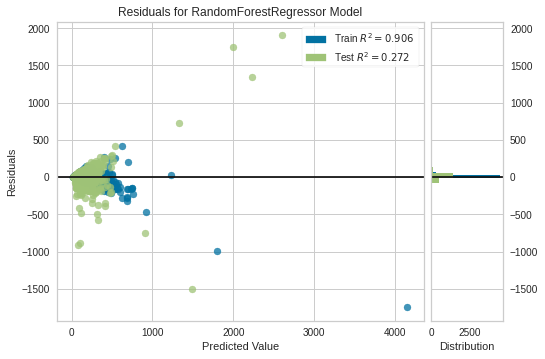

In [77]:
plot_model(rf, plot='residuals')

## Errors

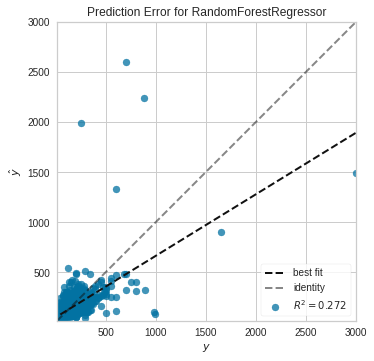

In [78]:
plot_model(rf, plot='error')

## Feature Importance

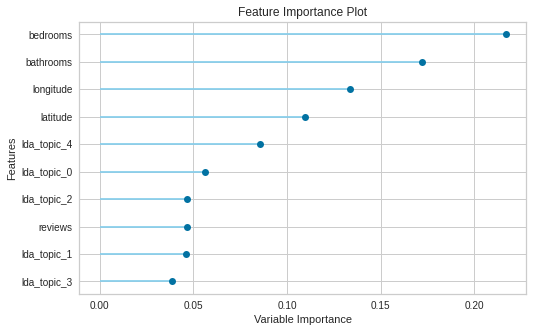

In [79]:
plot_model(rf, plot='feature')

In [80]:
predict_model(rf)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,40.0699,9456.0762,97.2424,0.2715,0.4106,0.3667


,reviews,overall_satisfaction,accommodates,bedrooms,bathrooms,latitude,longitude,lda_topic_0,lda_topic_1,lda_topic_2,lda_topic_3,lda_topic_4,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,currency_USD,rate_type_nightly,price,Label
0,57.0,5.000000,4.0,1.0,1.0,47.598509,-122.296287,0.110880,0.103946,0.147280,0.534676,0.103218,1.0,0.0,0.0,1.0,1.0,50,100.38
1,128.0,5.000000,6.0,1.0,1.0,47.606454,-122.309273,0.129107,0.105157,0.558850,0.103083,0.103802,1.0,0.0,0.0,1.0,1.0,70,95.51
2,101.0,5.000000,2.0,1.0,1.0,47.661216,-122.357403,0.124902,0.103507,0.566951,0.101223,0.103416,1.0,0.0,0.0,1.0,1.0,75,101.93
3,38.0,5.000000,4.0,1.0,1.0,47.639051,-122.325245,0.122244,0.105268,0.563071,0.104979,0.104438,1.0,0.0,0.0,1.0,1.0,135,108.20
4,287.0,5.000000,3.0,0.0,1.0,47.554861,-122.383546,0.118753,0.103141,0.573954,0.101051,0.103101,1.0,0.0,0.0,1.0,1.0,79,78.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,4.0,4.500000,2.0,1.0,1.5,47.693315,-122.377773,0.127465,0.103485,0.564330,0.101327,0.103394,0.0,1.0,0.0,1.0,1.0,45,71.77
2269,262.0,5.000000,2.0,0.0,1.0,47.620133,-122.316285,0.550529,0.101949,0.144156,0.101899,0.101468,1.0,0.0,0.0,1.0,1.0,62,60.71
2270,23.0,5.000000,2.0,1.0,1.0,47.671630,-122.385023,0.125442,0.105088,0.562695,0.103048,0.103727,1.0,0.0,0.0,1.0,1.0,95,99.14
2271,28.0,5.000000,2.0,1.0,1.0,47.515423,-122.365840,0.118889,0.103119,0.573874,0.101029,0.103089,0.0,1.0,0.0,1.0,1.0,50,50.03
